# Run ISPC

This script runs ISPC

## py conversion

In [1]:
#!jupyter nbconvert --to python isPc.ipynb

## Imports 

In [2]:
import warnings
import sys  
import random
# import logging

import deepdish as dd
import numpy as np

import brainiak.eventseg.event
import nibabel as nib
import nilearn as nil
# Import a function from BrainIAK to simulate fMRI data
import brainiak.utils.fmrisim as sim  

from nilearn.input_data import NiftiMasker

import scipy.io
from scipy import stats
from scipy.stats import norm, zscore, pearsonr
from scipy.signal import gaussian, convolve

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as patches
import seaborn as sns 



from brainiak import image, io
from scipy.stats import stats
import nibabel as nib
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

from nilearn import datasets, plotting
from nilearn.plotting import plot_roi
from nilearn.input_data import NiftiSpheresMasker

from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.image import concat_imgs, resample_img, mean_img,index_img
from nilearn import image
from nilearn import masking
from nilearn.plotting import view_img
from nilearn.image import resample_to_img

from nilearn.image import concat_imgs, resample_img, mean_img
from nilearn.plotting import view_img

import numpy as np 
import os
import os.path
import scipy.io
import nibabel as nib
from nilearn.input_data import NiftiMasker
from nilearn.masking import compute_epi_mask, compute_brain_mask, unmask
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import PredefinedSplit
from copy import deepcopy

# Brainiak # 
from brainiak import image, io 
from brainiak.isc import (isc, isfc, bootstrap_isc, permutation_isc,
                          timeshift_isc, phaseshift_isc,
                          compute_summary_statistic)
from brainiak.io import load_boolean_mask, load_images
from statsmodels.stats.multitest import multipletests
from nilearn.plotting import plot_stat_map
%matplotlib inline

/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/nilearn/datasets/__init__.py:90: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [3]:
random.seed(10)

## custom helper functions 

In [4]:
from utils_anal import load_epi_data, resample_atlas, get_network_labels

## directories 

In [5]:
top_dir = '/jukebox/graziano/coolCatIsaac/MEI'
data_dir = top_dir + "/data"
work_dir = data_dir + '/work'
mask_dir = work_dir + '/masks'
behav_dir = top_dir + '/data/behavioral'
rois_dir = data_dir + "/rois"
fmri_prep = data_dir + '/bids/derivatives/fmriprep'
conf_dir = work_dir + '/confs'
preproc_dir = work_dir + '/preproc'
isc_dir = work_dir + '/isc_dat'


## main vars 

In [6]:
### sub_list ###
"""

========================================================
===== ~~~ Summary ALL ~~~ ===== 
========================================================
Initially exclude: sub-001, sub-003, sub-011, sub-012, sub-014, sub-015, sub-029 (3+ runs still available tho)
Maybe exclude: sub-014, sub-024, sub-037 (No button presses)
Maybe exclude: sub-020, sub-022, sub-031
total exclude = 10


~~~~~~~ BEHAVIORAL ~~~~~~~~~~
~~~ Summary behavioral ~~~

========================================================
========================================================
No button presses: sub-014, sub-024, sub-037 

========================================================
========================================================
sub-003: Extra row observed for external, which was manually deleted. Should be fine to rerun -- i removed from bad_subs
    - current brushing: 87, TRUE: 88 for THREE runs. last run when there was an issue and scan had to be restarted
    - Scan 6 == 1 run of brushing
    - Scan 7 = 3 runs of brushing 
    - ** no idea when run 7 was started tho! will prolly need to throw out! For now we can process all
sub-014: NO internal OR external bpress, curious! ---should be fixed now
    - changed excel data to include two null columns
    - ALSO only 30 TRs for the second run epi data. i went into the room to adjust runny eyes. Data for this run is not usable. but after should
      be okay if u want to put in the effort 
sub-015: less than 24 runs ---should be fixed now w custom code (but keep out of main run cuz will throw an error otherwise )
    - SUMMARY: need to exclude the office run 3 for fMRI but can include run 3 in behavioral, no data at all for CAKE
    - DID NOT add the 'mov_name' component to the custom code, will need to implment from current iteration
    - **** Use external, ignore internal for now... cuz internal is fuqd. Can preprocess all 7 tho

~~~~~~~ FMRI ~~~~~~~~~~
~~~ Summary fMRI ~~~
sub002: 
 - appended two TRs onto the last run, copied from the third to last TR. should be good to use
sub-003, sub-012, sub-014, sub-015, sub-029: 
 - Five runs usable, will need to incorporate them at some point 
sub-001: external usable - first three runs 

========================================================
========================================================
subject 002: (usable, with adjustment)
    only has 92 INSTEAD OF 94 TRs for the FINAL run of shrek. i think cuz i turned off the scanner
    too soon, which didn't account for 4 TRs of buffer? Yep! end tr is 390, (388, 112179). so duplicate TRs maybe.
    - Temporarily eliminate! or duplicate TRs 
    
sub-003: (usable, 5 runs)
- Scan 6 == 1 run of brushing
- Scan 7 = 3 runs of brushing 
*** need to re-preprocess, then append 6 and 7 together; or just throw out this one cuz idk when scan started

sub-011: (usable)
- not preprocessed 
sub-012 (5 runs usable, one run idk)
- I'll need to post process. It seems that an earbud fell out while reading the directions for run 5 
summary: the fifth run  needs to be discarded. all others are usable.
see the behav data: 
sub_dic['External']['oragami']
{'run-1': {'start_tr': 94, 'end_tr': 188, 'bpress': -1},
 'run-2': {'start_tr': 188, 'end_tr': 282, 'bpress': [100.81657150003593]},
 'run-3': {'start_tr': 282, 'end_tr': 376, 'bpress': [88.26579949003644]},
 'run-4': {'start_tr': 378,
  'end_tr': 472,
  }
- you can see taht the start TR is 94!! that's becuz i had to go into the scan room during the instructions screen.
- this is producing the wrong indexing -- becuz the scan doesn't contain enough TRs according to the behavioral data:
    - run 4 of shrek only has 12 TRs because we start at TR 94.
- im not sure when the scan actually started, but if i wanted to try to include i could 
    set the start TR to 1 -- essentially suggesting that the first TR was collected on the external 'waiting 
    for TR' flip. might as well try at some point, but exclude for now
    - this would involve just subtracting 94 from all start end end TRs i think
See the excel behavioral file for further notes notes
this 

sub-014 - no button press data and 7 runs (5 runs usable, but no bpress)
    - same problem as above -- i went into the scanner room during the instructions period to wipe eyes
    {'run-1': {'start_tr': 237, 'end_tr': 323, 'bpress': -1},
     'run-2': {'start_tr': 329, 'end_tr': 415, 'bpress': -1},
     'run-3': {'start_tr': 417, 'end_tr': 503, 'bpress': -1},
     'run-4': {'start_tr': 509, 'end_tr': 595, 'bpress': -1}}

sub-029: (5 runs usable)
- scanner malfunction, maybe possible to stitch together run 6 cuz i started on the *tenth* TR

========================================================
========================================================
Left handed: (sub-020, sub-022, sub-032)
    - sub-020: also no button presses, appeared to be awake tho
    - sub-022: lefty
    - sub-031: ambidexterious, great data
========================================================
========================================================
"""

## adjusted sublist 
sub_list = [
    'sub-002', 'sub-004', 'sub-005','sub-006','sub-007','sub-008','sub-009','sub-010',
    'sub-013','sub-016','sub-017','sub-018','sub-019','sub-020','sub-021',
    'sub-022','sub-023','sub-024','sub-025','sub-026','sub-027','sub-028','sub-030','sub-031','sub-032',
    'sub-033','sub-034','sub-035','sub-036','sub-037','sub-038','sub-039','sub-040'
]

## ALL SUBLIST
sub_list = [
    'sub-002', 'sub-003', 'sub-004', 'sub-005','sub-006','sub-007','sub-008','sub-009','sub-010', 'sub-012',
    'sub-013','sub-014', 'sub-015', 'sub-016','sub-017','sub-018','sub-019','sub-020','sub-021',
    'sub-022','sub-023','sub-024','sub-025','sub-026','sub-027','sub-028', 'sub-029', 'sub-030','sub-031','sub-032',
    'sub-033','sub-034','sub-035','sub-036','sub-037','sub-038','sub-039','sub-040', 'sub-041'
]
###### LOADING VARS #######




In [7]:
## TR length of each movie ## 
mov_len_dic = {
'oragami' :  82,
'shrek' : 90,
'sherlock' : 98,
'brushing' : 88,
'cake' : 99,
'office' : 102    
}

voxel_num = 112179



# load atlas 

In [8]:
num_parc = 400

## should be 17 to run
num_net= 7

In [9]:
## fetch dataset
dataset = datasets.fetch_atlas_schaefer_2018(n_rois=num_parc, yeo_networks = num_net)

# get nii dataset location
atlas_filename = dataset.maps
## get *ROI* atlas labels
labels = dataset.labels

# resample loaded atlas 
atlas_nii, atlas_img = resample_atlas(atlas_filename, fmri_prep)

Loading data from /jukebox/graziano/coolCatIsaac/MEI/data/bids/derivatives/fmriprep/sub-007/ses-01/func/sub-007_ses-01_task-None_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
shape of run 2 is (78, 93, 65, 369) 

count parc:401
shape of atlas nii object (78, 93, 65)


### get network labels

In [10]:
# Load in network labels for each parcell, ALL network labels, and the middle parcel within each network
networks, network_labels, network_idxs = get_network_labels(num_parc, num_net)


two networks: ['L Vis', 'L SomMot'] 
 total nets: 14


# Select network for analysis and plot

In [65]:
# **17 NETWORK Get labels for parcels in left DMN A network** ## 
net_lab = 'R ContC' #'L DefaultB'  #'R ContC' #R DorsAttnB  #R VisPeri  #R SalVentAttnA #'R TempPar' #'L SomMotA'

## Target Conditions
targ_cond = "External"

## movie repetitions ##
#m_reps = 1
targ_run = 1

## Get labels associated with the target network ## 
targ_net = (np.array(networks) == net_lab).nonzero()[0] + 1

In [11]:
# **7 NETWORK Get labels for parcels in left DMN A network** ## 
net_lab = 'R DorsAttn'

## Target Conditions
targ_cond = "External"

## movie repetitions ##
#m_reps = 1
targ_run = 1

## Get labels associated with the target network ## 
targ_net = (np.array(networks) == net_lab).nonzero()[0] + 1


In [12]:
targ_net

array([271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283,
       284, 285, 286, 287, 288, 289, 290, 291, 292, 293])

In [73]:
for lab in network_labels:
    print(lab)

L Vis
L SomMot
L DorsAttn
L SalVentAttn
L Limbic
L Cont
L Default
R Vis
R SomMot
R DorsAttn
R SalVentAttn
R Limbic
R Cont
R Default


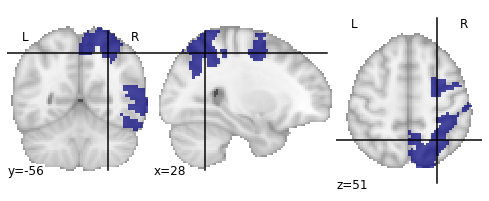

In [13]:
# Create an empty that is the shape of d
roi_tem = np.zeros(atlas_nii.shape)
# set all cases where parcel is equal to roi_num, equal to one, everything else zero (creates a mask)
for parcel in targ_net:
    roi_tem[atlas_img == parcel] = 1
    
# Create a nift image of the mask
roi_img = nib.Nifti1Image(roi_tem, affine = atlas_nii.affine, header = atlas_nii.header)
#nib.save(roi_img, rois_dir+'/'+ roi_name.decode("utf-8"))


mPFC_coords = (10,10, 45)
pcc_coords = (10,-40, 45)

#plot_roi(roi_img,cut_coords = pcc_coords)
plot_roi(roi_img)

# variables

In [14]:
# Get labels for parcels in left DMN A network
vox_roi = len(np.where(roi_tem ==1)[2])
print(f'using {net_lab} with {vox_roi} voxels')

using R DorsAttn with 3162 voxels


In [15]:
## Load mask
## mask image ##
mask_img = nib.load(mask_dir + "/whole_b_bnk.nii.gz")
#mask_img = nib.load(mask_dir + "/shaef_gm_MNI_mask.nii")


## how many TRs of buffer on the end? ## 
tr_buffer = 4 

# cuttoff the countdown -**effectivly shifts the timeseries over by 4
trim_start = 4 # cuts off first 4 TRs 

## number of runs to iterate over
epi_runs = 6

## load the runs to be included for each subject ## 
sub_run_inc = np.load(behav_dir + '/sub_run_inc.npy', allow_pickle = True).item()

## how many TRs to iterate around the button press
tr_range = np.arange(-3,10)

## which conditions ? ##

# this is the window which gannot be impeded by a second button press 
range_len = len(tr_range)
no_interfere = len(np.where(tr_range>0)[0])
print(f'total TRs to be extracted around the bpress: {range_len}\n total trs extracted post bpress: {no_interfere}')

total TRs to be extracted around the bpress: 13
 total trs extracted post bpress: 9


### begin

In [16]:
m_rep_int = {}
m_rep_ext = {}


for run in range(targ_run, targ_run + 1):
    external = {}
    internal = {}
    
    for sub in sub_list:
        ### fMRI load ###
        sub_dic_fmri = np.load(f'{preproc_dir}/{sub}_fwhm6_conf.npy', allow_pickle=True).item()
        print(f'start {sub}')
        ## BEHAVIORAL ##
        sub_dic_behav = np.load(os.path.join(behav_dir, f'{sub}_behav.npy'), allow_pickle=True).item()

        # Create subject number 
        sub_num = int(sub[-3:])

        for epi_index in range(0, epi_runs):
            # Add one to the index to create 1-6 runs
            epi_run = epi_index + 1

            # check if run is to be included 
            if not sub_run_inc[sub][epi_run]: continue

            # Get the movie name
            mov_name = sub_dic_behav['mov_order'][epi_index]

            # Create an empty array for the movie runs, append four TRs to account for the 4 trailing TRs, subtract
            # the quantity of TRs that we are trimming from the front 
            mov_runs = np.zeros((range_len, vox_roi, 0))

            print(f'movie: {mov_name} with shape {mov_runs.shape}')

            # Get the fMRI run for the current epi_index
            fmri_run = sub_dic_fmri[epi_run]

            # Loop over runs
            #for run in range(1, m_reps + 1):
            # Is this an internal or external run?
            key = 'External' if (sub_num % 2 == 1 and epi_index < 3) or (sub_num % 2 == 0 and epi_index >= 3) else 'Internal'

            ### only do internal for now ##
            #if key != targ_cond: continue

            ## get behavioral data
            bpress_arr = sub_dic_behav[key][mov_name][f'run-{str(run)}']['bpress']

            ## continue if no button presses
            if bpress_arr == -1:
                print(f'NO button presses {sub} {run}\n')
                continue


            # Begin slicing fMRI data #
            start_tr = sub_dic_behav[key][mov_name][f'run-{run:d}']['start_tr']
            end_tr = sub_dic_behav[key][mov_name][f'run-{run:d}']['end_tr']
            run_slice = fmri_run[(start_tr + trim_start):end_tr, :]
            print(f'run{run} bpress count is: {len(bpress_arr)}')
            print(f'start tr {start_tr}, end TR {end_tr}, length of fMRI run {fmri_run.shape}')
            assert fmri_run.shape[0] >= end_tr, 'end TR is greater than fMRI TRs available'

            # calculate differences between button presses, and append the time stamp of the end of scan
            difs = np.diff(np.hstack((bpress_arr, (end_tr - start_tr) * 1.5)))

            ## empty array to append if TR doesn't exist or conflicts with another button pres!
            empty = np.zeros((run_slice.shape[1])) ## number of voxels

            bpress_mat = []
            for idx, bpress in enumerate(bpress_arr):
                # Find the tr that each onset occured - convert from seconds to TR
                bpress_tr = round(bpress/1.5)
                print(f'\ntime of bpress {bpress},  tr is: {bpress_tr}, and next tr is {difs[idx]} away')
                assert bpress_tr < end_tr, print('TR extends past fMRI data, what on earth is going on!')

                temp = []
                ## for each tr in the TR range [likely this is 12 total trs]
                for num_tr in tr_range:
                    try:
                        # IF tr exists in the range of TRs add to temp array before averaging in the next step
                        current_bpress_tr = run_slice[bpress_tr+num_tr]
                        # if no error is thrown, run a check
                        if difs[idx] < 1.5 * num_tr:
                            temp.append(empty)
                            #print(f'INTERFERE DIF: cur TR is:{num_tr}, next bpress is {int(difs[idx] /1.5)} trs away')
                        else:
                            # add the correct voxel activation for the given TR 
                            temp.append(current_bpress_tr)
                            #print(f'CORRECT {current_bpress_tr[:3]}, length of TR activ is {len(current_bpress_tr)}')

                    except:
                        # if it doesn't exist, add an empty vector
                        temp.append(empty)
                        #print(f'INTERFERE Out of BNDS: bpress_tr {bpress_tr}, index {bpress_tr+num_tr}; total TRs {end_tr - start_tr}')
                    #print(f'FINISHED the {num_tr} TR')
                bpress_mat.append(temp)
                #print('FINISHED ONE BUTTN PRESS\n\n')

            ## convert list into numpy array
            bpress_mat = np.dstack(bpress_mat)
            print(f'num bpress: {len(bpress_arr)}, TRs: {bpress_mat.shape[0]}, voxels: {bpress_mat.shape[1]}')
            print(f'shape of bpress for {sub} is {bpress_mat.shape}')
            ## check that we have activation for at least one button press
            assert np.any(bpress_mat), f'NO BPRESSES FOR {sub}'

            ## once we've finished iterating over all button press, average each bpress matrix element-wise!
            #bpress_mat_av = np.mean(bpress_mat, axis =2)
            bpress_mat_av = np.nanmean(np.where(bpress_mat != 0, bpress_mat, np.nan), axis =2)
            # re-insert zeros after averaging, ignoring TRs that had no activation
            bpress_mat_av = np.where(bpress_mat_av != np.nan, bpress_mat_av, 0)

            # convert back to whole brain 4D image, instead of 2d
            bpress_nii = unmask(bpress_mat_av, mask_img)
            print(f'convert bpress averages back to nii: {bpress_nii.shape}')

            # Convert to 4d numpy array
            f_dat_4d = bpress_nii.get_fdata()

            targ_net = (np.array(networks) == net_lab).nonzero()[0] + 1

            # loop through all TRs and get the target voxel pattern #
            bpress_pat = np.column_stack([f_dat_4d[atlas_img == parcel, :].T
                            for parcel in targ_net])

            print(f'now extract voxel TR activations for target ROI: {np.dstack(bpress_pat).shape}\n\n')

            # expand to three dimensions for stacking 
            #bpress_pat_exp = np.expand_dims(np.dstack(bpress_pat), 2)
            bpress_pat_exp = np.expand_dims(bpress_pat, 2)
            #print(f'expand! {bpress_pat.shape}')

            # Stack the run slice with the mov_runs array
            #mov_runs = np.dstack((mov_runs, bpress_pat))
            mov_runs = np.dstack((mov_runs, bpress_pat_exp))
            print(f'stacked! {mov_runs.shape}')
            #assert mov_runs.shape[2] == 4, 'wrong numer of repetitions'

            # set outer loop #
            if key == 'External':
                target_dict = external
            else:
                target_dict = internal

            if mov_name not in target_dict:
                target_dict[mov_name] = mov_runs
            else:
                #mov_runs = np.expand_dims(mov_runs, 3)
                target_dict[mov_name] = np.dstack((target_dict[mov_name], mov_runs))
        print(f'\n subject {sub} finished \n')

    ## save into a repetition dictionary ## 
    m_rep_ext[run] = external
    m_rep_int[run] = internal



    print('done')








start sub-002
movie: shrek with shape (13, 3162, 0)
NO button presses sub-002 1

movie: sherlock with shape (13, 3162, 0)
run1 bpress count is: 2
start tr 7, end TR 109, length of fMRI run (417, 112179)

time of bpress 10.1,  tr is: 7, and next tr is 0.0 away

time of bpress 10.1,  tr is: 7, and next tr is 142.9 away
num bpress: 2, TRs: 13, voxels: 112179
shape of bpress for sub-002 is (13, 112179, 2)


/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: Mean of empty slice


convert bpress averages back to nii: (78, 93, 65, 13)
now extract voxel TR activations for target ROI: (1, 3162, 13)


stacked! (13, 3162, 1)
movie: oragami with shape (13, 3162, 0)
run1 bpress count is: 2
start tr 7, end TR 93, length of fMRI run (355, 112179)

time of bpress 10.1,  tr is: 7, and next tr is 0.0 away

time of bpress 10.1,  tr is: 7, and next tr is 118.9 away
num bpress: 2, TRs: 13, voxels: 112179
shape of bpress for sub-002 is (13, 112179, 2)
convert bpress averages back to nii: (78, 93, 65, 13)
now extract voxel TR activations for target ROI: (1, 3162, 13)


stacked! (13, 3162, 1)
movie: office with shape (13, 3162, 0)
run1 bpress count is: 2
start tr 8, end TR 114, length of fMRI run (437, 112179)

time of bpress 34.00292439600162,  tr is: 23, and next tr is 47.079010672998265 away

time of bpress 81.08193506899988,  tr is: 54, and next tr is 77.91806493100012 away
num bpress: 2, TRs: 13, voxels: 112179
shape of bpress for sub-002 is (13, 112179, 2)
convert bpress av

num bpress: 7, TRs: 13, voxels: 112179
shape of bpress for sub-004 is (13, 112179, 7)
convert bpress averages back to nii: (78, 93, 65, 13)
now extract voxel TR activations for target ROI: (1, 3162, 13)


stacked! (13, 3162, 1)
movie: oragami with shape (13, 3162, 0)
run1 bpress count is: 6
start tr 7, end TR 93, length of fMRI run (354, 112179)

time of bpress 16.124013221997302,  tr is: 11, and next tr is 4.5599229309591465 away

time of bpress 20.68393615295645,  tr is: 14, and next tr is 10.894977210031357 away

time of bpress 31.578913362987805,  tr is: 21, and next tr is 20.975116247020196 away

time of bpress 52.554029610008,  tr is: 35, and next tr is 16.95591122994665 away

time of bpress 69.50994083995465,  tr is: 46, and next tr is 38.69798332004575 away

time of bpress 108.2079241600004,  tr is: 72, and next tr is 20.792075839999598 away
num bpress: 6, TRs: 13, voxels: 112179
shape of bpress for sub-004 is (13, 112179, 6)
convert bpress averages back to nii: (78, 93, 65, 13

num bpress: 6, TRs: 13, voxels: 112179
shape of bpress for sub-007 is (13, 112179, 6)
convert bpress averages back to nii: (78, 93, 65, 13)
now extract voxel TR activations for target ROI: (1, 3162, 13)


stacked! (13, 3162, 1)
movie: cake with shape (13, 3162, 0)
run1 bpress count is: 8
start tr 7, end TR 110, length of fMRI run (423, 112179)

time of bpress 12.074442808981985,  tr is: 8, and next tr is 21.228990382049233 away

time of bpress 33.30343319103122,  tr is: 22, and next tr is 29.123116613947786 away

time of bpress 62.426549804979004,  tr is: 42, and next tr is 38.14888084202539 away

time of bpress 100.5754306470044,  tr is: 67, and next tr is 6.43000644503627 away

time of bpress 107.00543709204067,  tr is: 71, and next tr is 11.01400703494437 away

time of bpress 118.01944412698504,  tr is: 79, and next tr is 10.055953242001124 away

time of bpress 128.07539736898616,  tr is: 85, and next tr is 13.454013893962838 away

time of bpress 141.529411262949,  tr is: 94, and ne

start sub-010
movie: shrek with shape (13, 3162, 0)
run1 bpress count is: 10
start tr 13, end TR 107, length of fMRI run (396, 112179)

time of bpress 11.767989402986132,  tr is: 8, and next tr is 7.515987104969099 away

time of bpress 19.28397650795523,  tr is: 13, and next tr is 10.362009040080011 away

time of bpress 29.64598554803524,  tr is: 20, and next tr is 12.899022877914831 away

time of bpress 42.54500842595007,  tr is: 28, and next tr is 11.697997593088076 away

time of bpress 54.24300601903815,  tr is: 36, and next tr is 5.325987708987668 away

time of bpress 59.568993728025816,  tr is: 40, and next tr is 8.914003781974316 away

time of bpress 68.48299751000013,  tr is: 46, and next tr is 13.91200095997192 away

time of bpress 82.39499846997205,  tr is: 55, and next tr is 22.47902138507925 away

time of bpress 104.8740198550513,  tr is: 70, and next tr is 22.970845553907566 away

time of bpress 127.84486540895887,  tr is: 85, and next tr is 13.155134591041133 away
num bpre

convert bpress averages back to nii: (78, 93, 65, 13)
now extract voxel TR activations for target ROI: (1, 3162, 13)


stacked! (13, 3162, 1)
movie: brushing with shape (13, 3162, 0)
run1 bpress count is: 2
start tr 11, end TR 103, length of fMRI run (392, 112179)

time of bpress 87.65378986799624,  tr is: 58, and next tr is 27.460007285000756 away

time of bpress 115.113797152997,  tr is: 77, and next tr is 22.886202847003005 away
num bpress: 2, TRs: 13, voxels: 112179
shape of bpress for sub-013 is (13, 112179, 2)
convert bpress averages back to nii: (78, 93, 65, 13)
now extract voxel TR activations for target ROI: (1, 3162, 13)


stacked! (13, 3162, 1)
movie: office with shape (13, 3162, 0)
NO button presses sub-013 1

movie: oragami with shape (13, 3162, 0)
run1 bpress count is: 7
start tr 8, end TR 94, length of fMRI run (371, 112179)

time of bpress 23.662532743997872,  tr is: 16, and next tr is 34.17300820501987 away

time of bpress 57.83554094901774,  tr is: 39, and next tr is 

convert bpress averages back to nii: (78, 93, 65, 13)
now extract voxel TR activations for target ROI: (1, 3162, 13)


stacked! (13, 3162, 1)
movie: oragami with shape (13, 3162, 0)
run1 bpress count is: 3
start tr 6, end TR 92, length of fMRI run (352, 112179)

time of bpress 14.64172462397255,  tr is: 10, and next tr is 28.753970253048465 away

time of bpress 43.395694877021015,  tr is: 29, and next tr is 77.56402691500261 away

time of bpress 120.95972179202363,  tr is: 81, and next tr is 8.040278207976371 away
num bpress: 3, TRs: 13, voxels: 112179
shape of bpress for sub-016 is (13, 112179, 3)
convert bpress averages back to nii: (78, 93, 65, 13)
now extract voxel TR activations for target ROI: (1, 3162, 13)


stacked! (13, 3162, 1)
movie: sherlock with shape (13, 3162, 0)
run1 bpress count is: 1
start tr 7, end TR 109, length of fMRI run (417, 112179)

time of bpress 15.680049269925803,  tr is: 10, and next tr is 137.3199507300742 away
num bpress: 1, TRs: 13, voxels: 112179
shape

convert bpress averages back to nii: (78, 93, 65, 13)
now extract voxel TR activations for target ROI: (1, 3162, 13)


stacked! (13, 3162, 1)
movie: brushing with shape (13, 3162, 0)
run1 bpress count is: 4
start tr 11, end TR 103, length of fMRI run (394, 112179)

time of bpress 36.03933862700069,  tr is: 24, and next tr is 45.969878650998 away

time of bpress 82.00921727799869,  tr is: 55, and next tr is 33.19203262399242 away

time of bpress 115.2012499019911,  tr is: 77, and next tr is 13.562000504010939 away

time of bpress 128.76325040600204,  tr is: 86, and next tr is 9.236749593997956 away
num bpress: 4, TRs: 13, voxels: 112179
shape of bpress for sub-018 is (13, 112179, 4)
convert bpress averages back to nii: (78, 93, 65, 13)
now extract voxel TR activations for target ROI: (1, 3162, 13)


stacked! (13, 3162, 1)
movie: office with shape (13, 3162, 0)
run1 bpress count is: 1
start tr 9, end TR 115, length of fMRI run (447, 112179)

time of bpress 64.97099067200907,  tr is: 43, 

num bpress: 8, TRs: 13, voxels: 112179
shape of bpress for sub-019 is (13, 112179, 8)
convert bpress averages back to nii: (78, 93, 65, 13)
now extract voxel TR activations for target ROI: (1, 3162, 13)


stacked! (13, 3162, 1)

 subject sub-019 finished 

start sub-020
movie: office with shape (13, 3162, 0)
NO button presses sub-020 1

movie: cake with shape (13, 3162, 0)
NO button presses sub-020 1

movie: brushing with shape (13, 3162, 0)
NO button presses sub-020 1

movie: shrek with shape (13, 3162, 0)
NO button presses sub-020 1

movie: oragami with shape (13, 3162, 0)
NO button presses sub-020 1

movie: sherlock with shape (13, 3162, 0)
NO button presses sub-020 1


 subject sub-020 finished 

start sub-021
movie: cake with shape (13, 3162, 0)
run1 bpress count is: 4
start tr 16, end TR 119, length of fMRI run (440, 112179)

time of bpress 75.23678340995684,  tr is: 50, and next tr is 21.585996706970036 away

time of bpress 96.82278011692688,  tr is: 65, and next tr is 16.412996

convert bpress averages back to nii: (78, 93, 65, 13)
now extract voxel TR activations for target ROI: (1, 3162, 13)


stacked! (13, 3162, 1)

 subject sub-022 finished 

start sub-023
movie: sherlock with shape (13, 3162, 0)
NO button presses sub-023 1

movie: oragami with shape (13, 3162, 0)
run1 bpress count is: 2
start tr 10, end TR 96, length of fMRI run (367, 112179)

time of bpress 16.084479618933983,  tr is: 11, and next tr is 91.64800741907675 away

time of bpress 107.73248703801073,  tr is: 72, and next tr is 21.26751296198927 away
num bpress: 2, TRs: 13, voxels: 112179
shape of bpress for sub-023 is (13, 112179, 2)
convert bpress averages back to nii: (78, 93, 65, 13)
now extract voxel TR activations for target ROI: (1, 3162, 13)


stacked! (13, 3162, 1)
movie: shrek with shape (13, 3162, 0)
run1 bpress count is: 2
start tr 10, end TR 104, length of fMRI run (402, 112179)

time of bpress 104.95660279900767,  tr is: 70, and next tr is 21.89695871900767 away

time of bpress 12

convert bpress averages back to nii: (78, 93, 65, 13)
now extract voxel TR activations for target ROI: (1, 3162, 13)


stacked! (13, 3162, 1)
movie: office with shape (13, 3162, 0)
NO button presses sub-025 1

movie: oragami with shape (13, 3162, 0)
run1 bpress count is: 9
start tr 11, end TR 97, length of fMRI run (359, 112179)

time of bpress 5.980683028930798,  tr is: 4, and next tr is 8.493101112078875 away

time of bpress 14.473784141009673,  tr is: 10, and next tr is 21.09493589703925 away

time of bpress 35.56872003804892,  tr is: 24, and next tr is 40.42008991190232 away

time of bpress 75.98880994995125,  tr is: 51, and next tr is 5.078880565939471 away

time of bpress 81.06769051589072,  tr is: 54, and next tr is 5.734039752045646 away

time of bpress 86.80173026793636,  tr is: 58, and next tr is 14.236003630096093 away

time of bpress 101.03773389803246,  tr is: 67, and next tr is 16.984005386941135 away

time of bpress 118.02173928497359,  tr is: 79, and next tr is 3.591973

convert bpress averages back to nii: (78, 93, 65, 13)
now extract voxel TR activations for target ROI: (1, 3162, 13)


stacked! (13, 3162, 1)
movie: brushing with shape (13, 3162, 0)
run1 bpress count is: 2
start tr 8, end TR 100, length of fMRI run (379, 112179)

time of bpress 83.76307602622546,  tr is: 56, and next tr is 42.40702657587826 away

time of bpress 126.17010260210373,  tr is: 84, and next tr is 11.829897397896275 away
num bpress: 2, TRs: 13, voxels: 112179
shape of bpress for sub-027 is (13, 112179, 2)
convert bpress averages back to nii: (78, 93, 65, 13)
now extract voxel TR activations for target ROI: (1, 3162, 13)


stacked! (13, 3162, 1)

 subject sub-027 finished 

start sub-028
movie: brushing with shape (13, 3162, 0)
run1 bpress count is: 3
start tr 11, end TR 103, length of fMRI run (408, 112179)

time of bpress 27.4925813539885,  tr is: 18, and next tr is 53.672999722883105 away

time of bpress 81.1655810768716,  tr is: 54, and next tr is 37.64898091019131 away



convert bpress averages back to nii: (78, 93, 65, 13)
now extract voxel TR activations for target ROI: (1, 3162, 13)


stacked! (13, 3162, 1)

 subject sub-029 finished 

start sub-030
movie: oragami with shape (13, 3162, 0)
run1 bpress count is: 1
start tr 19, end TR 105, length of fMRI run (379, 112179)

time of bpress 53.38652355992235,  tr is: 36, and next tr is 75.61347644007765 away
num bpress: 1, TRs: 13, voxels: 112179
shape of bpress for sub-030 is (13, 112179, 1)
convert bpress averages back to nii: (78, 93, 65, 13)
now extract voxel TR activations for target ROI: (1, 3162, 13)


stacked! (13, 3162, 1)
movie: sherlock with shape (13, 3162, 0)
run1 bpress count is: 3
start tr 9, end TR 111, length of fMRI run (422, 112179)

time of bpress 18.556125592906028,  tr is: 12, and next tr is 18.451001573121175 away

time of bpress 37.0071271660272,  tr is: 25, and next tr is 93.59700779104605 away

time of bpress 130.60413495707326,  tr is: 87, and next tr is 22.395865042926744 away


start sub-032
movie: cake with shape (13, 3162, 0)
NO button presses sub-032 1

movie: brushing with shape (13, 3162, 0)
run1 bpress count is: 4
start tr 7, end TR 99, length of fMRI run (383, 112179)

time of bpress 58.16177683742717,  tr is: 39, and next tr is 11.13389447890222 away

time of bpress 69.29567131632939,  tr is: 46, and next tr is 40.55800588103011 away

time of bpress 109.8536771973595,  tr is: 73, and next tr is 10.034015575889498 away

time of bpress 119.887692773249,  tr is: 80, and next tr is 18.112307226751 away
num bpress: 4, TRs: 13, voxels: 112179
shape of bpress for sub-032 is (13, 112179, 4)
convert bpress averages back to nii: (78, 93, 65, 13)
now extract voxel TR activations for target ROI: (1, 3162, 13)


stacked! (13, 3162, 1)
movie: office with shape (13, 3162, 0)
run1 bpress count is: 2
start tr 7, end TR 113, length of fMRI run (450, 112179)

time of bpress 52.47381783183664,  tr is: 35, and next tr is 45.45600579911843 away

time of bpress 97.929823630

num bpress: 19, TRs: 13, voxels: 112179
shape of bpress for sub-033 is (13, 112179, 19)
convert bpress averages back to nii: (78, 93, 65, 13)
now extract voxel TR activations for target ROI: (1, 3162, 13)


stacked! (13, 3162, 1)
movie: sherlock with shape (13, 3162, 0)
run1 bpress count is: 19
start tr 8, end TR 110, length of fMRI run (418, 112179)

time of bpress 11.502010958269238,  tr is: 8, and next tr is 6.306019423063844 away

time of bpress 17.808030381333083,  tr is: 12, and next tr is 3.3919637496583164 away

time of bpress 21.1999941309914,  tr is: 14, and next tr is 1.6370179583318532 away

time of bpress 22.837012089323252,  tr is: 15, and next tr is 1.8860286297276616 away

time of bpress 24.723040719050914,  tr is: 16, and next tr is 2.01195966033265 away

time of bpress 26.735000379383564,  tr is: 18, and next tr is 2.4210279756225646 away

time of bpress 29.15602835500613,  tr is: 19, and next tr is 2.0540116033516824 away

time of bpress 31.21003995835781,  tr is: 21

convert bpress averages back to nii: (78, 93, 65, 13)
now extract voxel TR activations for target ROI: (1, 3162, 13)


stacked! (13, 3162, 1)

 subject sub-034 finished 

start sub-035
movie: sherlock with shape (13, 3162, 0)
run1 bpress count is: 3
start tr 14, end TR 116, length of fMRI run (429, 112179)

time of bpress 21.72566445823759,  tr is: 14, and next tr is 23.342960379552096 away

time of bpress 45.068624837789685,  tr is: 30, and next tr is 25.160007518250495 away

time of bpress 70.22863235604018,  tr is: 47, and next tr is 82.77136764395982 away
num bpress: 3, TRs: 13, voxels: 112179
shape of bpress for sub-035 is (13, 112179, 3)
convert bpress averages back to nii: (78, 93, 65, 13)
now extract voxel TR activations for target ROI: (1, 3162, 13)


stacked! (13, 3162, 1)
movie: shrek with shape (13, 3162, 0)
run1 bpress count is: 2
start tr 13, end TR 107, length of fMRI run (391, 112179)

time of bpress 98.86880542291328,  tr is: 66, and next tr is 23.021005830261856 away


num bpress: 8, TRs: 13, voxels: 112179
shape of bpress for sub-038 is (13, 112179, 8)
convert bpress averages back to nii: (78, 93, 65, 13)
now extract voxel TR activations for target ROI: (1, 3162, 13)


stacked! (13, 3162, 1)
movie: shrek with shape (13, 3162, 0)
run1 bpress count is: 4
start tr 15, end TR 109, length of fMRI run (405, 112179)

time of bpress 14.308931749779731,  tr is: 10, and next tr is 20.699024656787515 away

time of bpress 35.007956406567246,  tr is: 23, and next tr is 33.60707768704742 away

time of bpress 68.61503409361467,  tr is: 46, and next tr is 38.09192329598591 away

time of bpress 106.70695738960057,  tr is: 71, and next tr is 34.293042610399425 away
num bpress: 4, TRs: 13, voxels: 112179
shape of bpress for sub-038 is (13, 112179, 4)
convert bpress averages back to nii: (78, 93, 65, 13)
now extract voxel TR activations for target ROI: (1, 3162, 13)


stacked! (13, 3162, 1)
movie: sherlock with shape (13, 3162, 0)
run1 bpress count is: 14
start tr 33, 

convert bpress averages back to nii: (78, 93, 65, 13)
now extract voxel TR activations for target ROI: (1, 3162, 13)


stacked! (13, 3162, 1)
movie: brushing with shape (13, 3162, 0)
run1 bpress count is: 7
start tr 8, end TR 100, length of fMRI run (383, 112179)

time of bpress 22.136810187250376,  tr is: 15, and next tr is 11.451029716059566 away

time of bpress 33.58783990330994,  tr is: 22, and next tr is 16.080995715688914 away

time of bpress 49.668835618998855,  tr is: 33, and next tr is 21.194027695339173 away

time of bpress 70.86286331433803,  tr is: 47, and next tr is 7.134961255826056 away

time of bpress 77.99782457016408,  tr is: 52, and next tr is 15.098019390832633 away

time of bpress 93.09584396099672,  tr is: 62, and next tr is 28.128029566258192 away

time of bpress 121.22387352725491,  tr is: 81, and next tr is 16.77612647274509 away
num bpress: 7, TRs: 13, voxels: 112179
shape of bpress for sub-040 is (13, 112179, 7)
convert bpress averages back to nii: (78, 93, 6

In [ ]:
np.savez_compressed(f'{isc_dir}/ext_isc.npz', **ext_isc)
np.savez_compressed(f'{isc_dir}/int_isc.npz', **int_isc)

# ISC ANAL

In [23]:
#anal = m_rep_int[4]['sherlock']
anal = m_rep_ext[1]['sherlock']

anal.shape

(13, 1124, 9)

In [24]:
# Transpose input data to compute intersubject pattern correlation
ispcs = isfc(np.rollaxis(anal, 1, 0),
                    pairwise=False, vectorize_isfcs=False,
                    summary_statistic='mean')

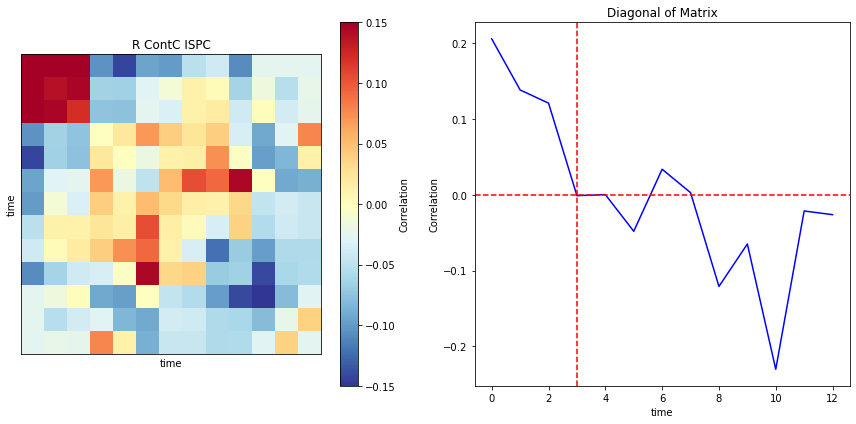

In [25]:
# Plot time-point-by-time-point intersubject pattern correlation
vmin, vmax = -0.15, 0.15

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# First plot: Matrix
ispc = ispcs  # Choose the matrix to plot (intact_ispcs or scram_ispcs)
title = f'{net_lab} ISPC'  # Choose the appropriate title
image = axs[0].matshow(ispc, vmin=vmin, vmax=vmax, cmap='RdYlBu_r')
axs[0].set_title(title)
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_xlabel('time')
axs[0].set_ylabel('time')
cbar = plt.colorbar(image, ax=axs[0])  # Add colorbar
cbar.set_label('Correlation')  # Set colorbar label

# Second plot: Seaborn lineplot with vertical line
diagonal = np.diagonal(ispc)
time_points = np.arange(len(diagonal))
axs[1] = sns.lineplot(x=time_points, y=diagonal, color='blue')
axs[1].set_title('Diagonal of Matrix')
axs[1].set_xlabel('time')
axs[1].set_ylabel('Correlation')
axs[1].axvline(x=3, color='red', linestyle='--')  # Vertical line at the third tick
axs[1].axhline(y=0, color='red', linestyle='--')  # Horizotnal line at 0


plt.tight_layout()
plt.show()
